In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import numpy as np


# 데이터 전처리

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


170498071/170498071 [==============================] - 14s 0us/step


# 데이터 시각화

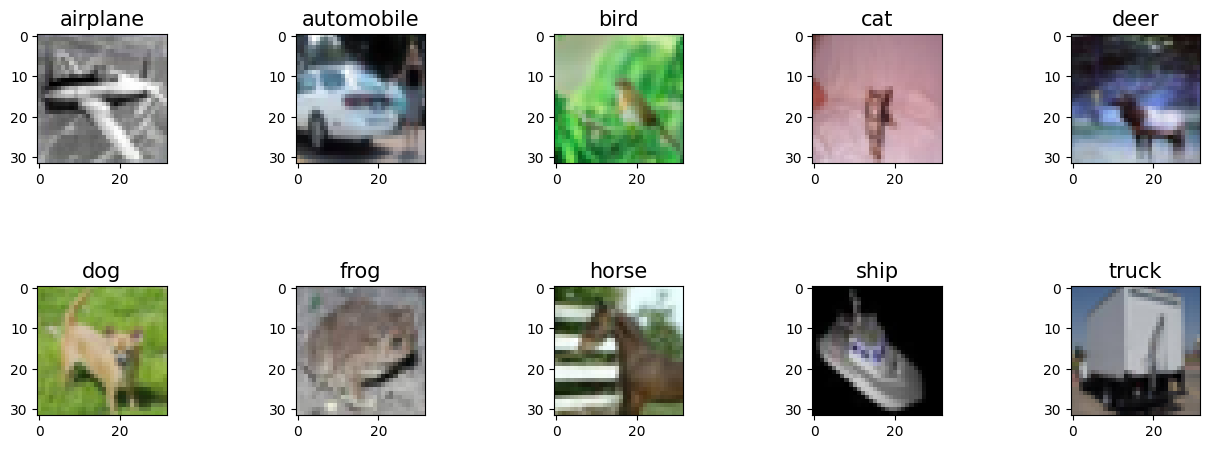

In [5]:

# CIFAR10 데이터셋의 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in np.arange(0, 10):
    # 각 클래스에 해당하는 인덱스 찾기
    indices = np.where(np.argmax(y_train, axis=1) == i)[0]

    # 그 중 하나를 랜덤하게 선택하기
    idx = np.random.choice(indices)

    # 선택된 이미지 표시하기
    axes[i].imshow(x_train[idx])
    axes[i].set_title(class_names[i], fontsize=15)
    plt.subplots_adjust(wspace=1)


# 데이터 증강

In [6]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)


# 생성된 이미지를 시각화

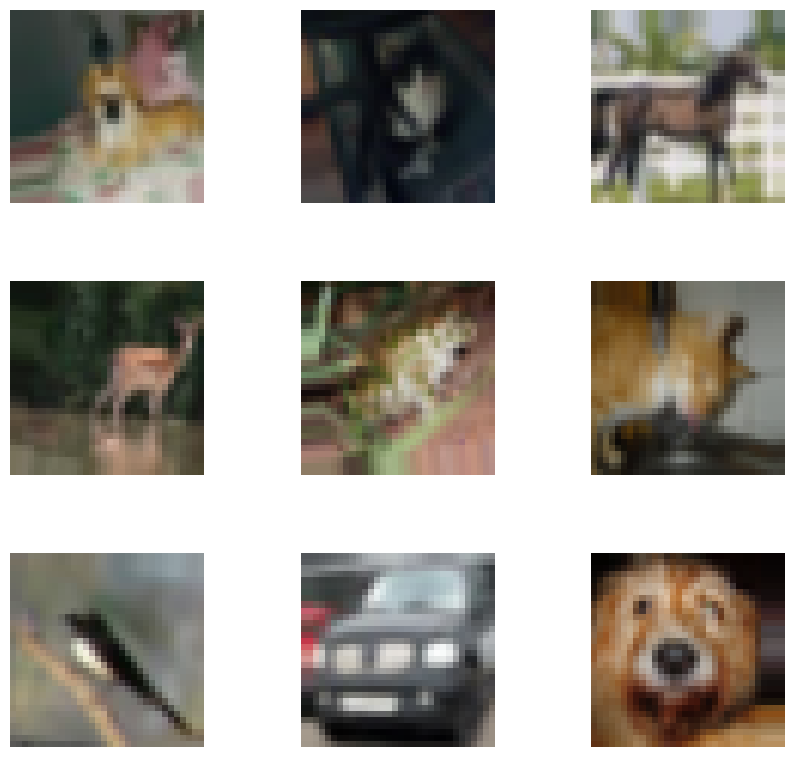

In [7]:
# 9개의 무작위 인덱스를 선택합니다.
indices = np.random.randint(0, x_train.shape[0], size=9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    # 선택된 인덱스에 해당하는 이미지를 가져옵니다.
    img = x_train[indices[i]:indices[i]+1]

    # 이 이미지에 대해 데이터 증강을 수행합니다.
    it = datagen.flow(img, batch_size=1)

    # 데이터 증강 기능을 통해 생성된 첫 번째 (즉 다음) 이미지를 가져옵니다.
    augmented_img = (it.next()[0]*255).astype('uint8')

    # 이미지 출력
    axes[i].imshow(augmented_img)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)



# 사전 훈련된 ResNet50 모델 로드

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False)

# The layers of the base model are not frozen and will be updated during training.

x = base_model.output

# Add a global spatial average pooling layer.
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer.
x = Dense(512, activation='relu')(x)

# Add a logistic layer with the number of classes in the CIFAR-10 dataset (in this case it's 10).
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



94765736/94765736 [==============================] - 5s 0us/step


# 모델 컴파일

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델확인

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

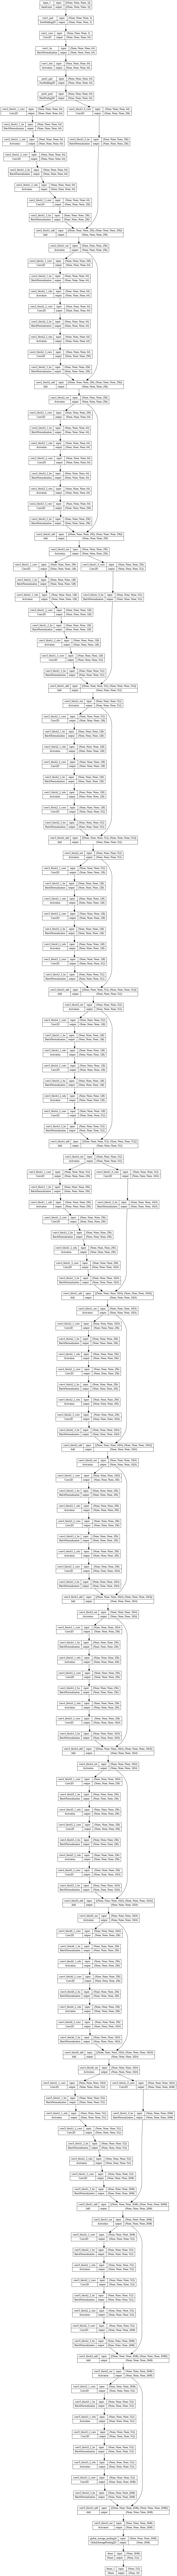

In [11]:
plot_model(model, to_file='resnet50.png', show_shapes=True, show_layer_names=True)

# 얼리스탑 콜백 정의

In [12]:
early_stopping_callback = EarlyStopping(monitor='loss', patience=10)

# 모델 학습

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

train_generator = train_datagen.flow(x_train, y_train, batch_size=128)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=100,
    callbacks=[early_stopping_callback])

Epoch 1/100
390/390 [==============================] - 90s 100ms/step - loss: 1.3895 - accuracy: 0.5303
Epoch 2/100
390/390 [==============================] - 39s 100ms/step - loss: 0.8523 - accuracy: 0.7057
Epoch 3/100
390/390 [==============================] - 37s 95ms/step - loss: 0.6896 - accuracy: 0.7611
Epoch 4/100
390/390 [==============================] - 37s 94ms/step - loss: 0.5953 - accuracy: 0.7913
Epoch 5/100
390/390 [==============================] - 38s 96ms/step - loss: 0.5257 - accuracy: 0.8170
Epoch 6/100
390/390 [==============================] - 38s 97ms/step - loss: 0.4722 - accuracy: 0.8361
Epoch 7/100
390/390 [==============================] - 38s 97ms/step - loss: 0.4235 - accuracy: 0.8524
Epoch 8/100
390/390 [==============================] - 37s 95ms/step - loss: 0.3883 - accuracy: 0.8648
Epoch 9/100
390/390 [==============================] - 38s 98ms/step - loss: 0.3586 - accuracy: 0.8728
Epoch 10/100
390/390 [==============================] - 38s 97ms/step -

# 평가

In [14]:
score = model.evaluate(x_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 12ms/step - loss: 0.8799 - accuracy: 0.8379
Test loss: 0.879874050617218
Test accuracy: 0.8378999829292297


# 학습 과정 시각화

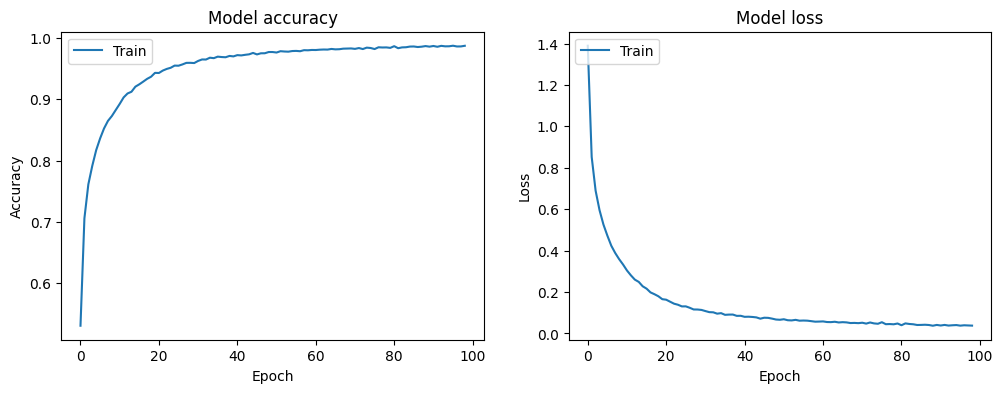

In [17]:
# Plot training accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Show the plot
plt.show()



313/313 [==============================] - 5s 12ms/step


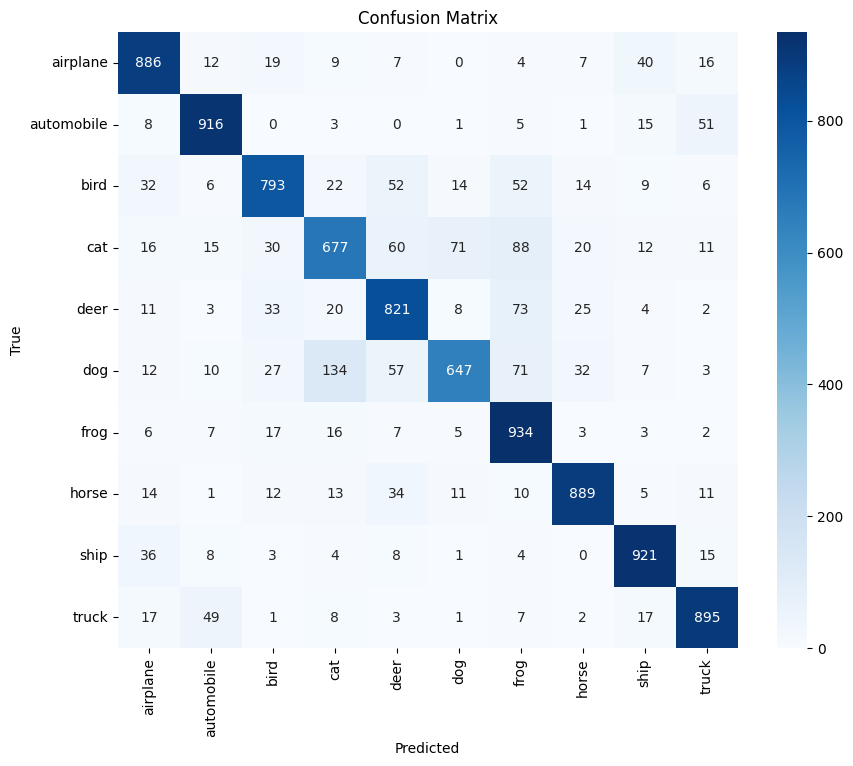

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 모델 예측값 구하기
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 컨퓨전 매트릭스 생성
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 컨퓨전 매트릭스 시각화
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

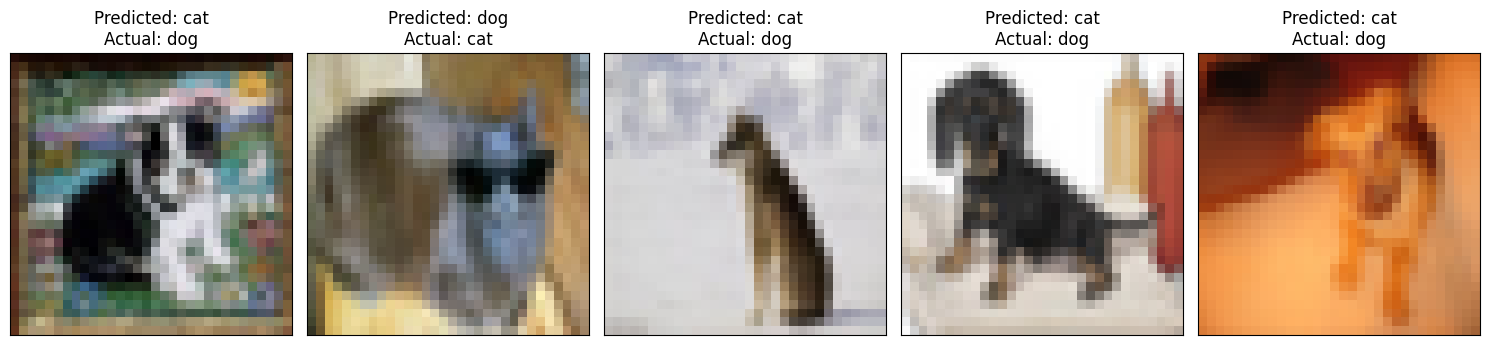

In [19]:
dog_indices = np.where((y_pred_classes == 5) & (y_true == 3))[0]  # 모델이 "개"로 예측했지만 실제는 "고양이"
cat_indices = np.where((y_pred_classes == 3) & (y_true == 5))[0]  # 모델이 "고양이"로 예측했지만 실제는 "개"

misclassified_indices = np.concatenate((dog_indices, cat_indices))

# 잘못 분류된 개와 고양이 이미지 중에서 무작위로 다섯 개 선택
random_misclassified_indices = np.random.choice(misclassified_indices, size=5, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_misclassified_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx])
    plt.title(f"Predicted: {class_names[y_pred_classes[idx]]}\nActual: {class_names[y_true[idx]]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

